In [ ]:
!pip install torch torchvision
!pip install Pillow==4.0.0

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models
from PIL import Image
import torch
import torch.optim as optim

In [3]:
vgg = models.vgg19(pretrained = True).features

for param in vgg.parameters():
  param.requires_grad_(False)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
os.getcwd()

'/content'

In [7]:
os.chdir('/content/drive/My Drive/NST Images')

In [8]:
def load_image(image_path, max_size = 400, shape = None):

  image = Image.open(image_path).convert('RGB')
  if max(image.size) > max_size:
    size = max_size

  else:
    size = max(image.size)

  if shape is not None:
    size = shape

  im_transform = transforms.Compose([
                                     transforms.Resize(size),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5),
                                                          (0.5, 0.5, 0.5))
  ])      

  image = im_transform(image).unsqueeze(0)
  return image

In [9]:
content = load_image('City.jpg').to(device)
style = load_image('StarryNight.jpg').to(device)

In [10]:
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach().numpy()
  image = image.squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

(-0.5, 615.5, 399.5, -0.5)

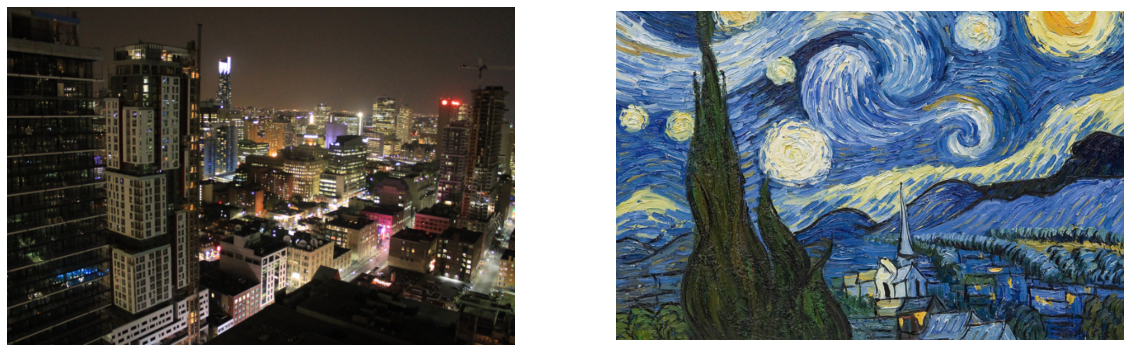

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(im_convert(content))
ax1.axis("off")

ax2.imshow(im_convert(style))
ax2.axis("off")

In [12]:
def get_features(image, model):

  layers = {
      '0' : 'conv1_1',
      '5' : 'conv2_1',
      '10' : 'conv3_1',
      '19' : 'conv4_1',
      '21' : 'conv4_2', #this is for content extraction , style extraction is tough and needs 4 layers
      '28' : 'conv5_1'
  }

  features = {}

  for name, layer in model._modules.items():
    image = layer(image)

    if name in layers:
      features[layers[name]] = image

  return features    

In [13]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)


In [14]:
def gram_matrix(tensor):
  
  b, d, h, w = tensor.size() #unpacking
  tensor = tensor.view(d, h * w)  #matrix in 2D
  gram = torch.mm(tensor, tensor.t())  #A * ATranspose is gram matrix
  return gram


In [15]:
style_grams = {layer : gram_matrix(style_features[layer]) for layer in style_features}

In [16]:
style_weights = {
    'conv1_1' : 1.,
    'conv2_1' : 0.75,
    'conv3_1' : 0.2,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2
}

#take alpha beta ratio which is the ratio between the content and style image in the final target

content_weight = 1 #alpha
style_weight = 1e6 #beta

In [17]:
target = content.clone().requires_grad_(True).to(device) #instead of starting from noise, we start from the content image and start adding style to it

In [18]:
show_every = 300
steps = 7800
optimizer = optim.Adam([target], lr = 0.003)  #we optimize the pixels of the target img - loss func min so that content is retained as much as possible and style is added (gram matrices of target and style img at each of the style layers should be as similar as possible)

height, width, channels = im_convert(target).shape
image_array = np.empty(shape = (300, height, width, channels)) # to visualize in the end as a video
capture_frame = steps / 300 #capture a frame every 300 iterations
counter = 0 #keep count of the index in the video array

Total Loss:  3144074.75
Iteration:  300


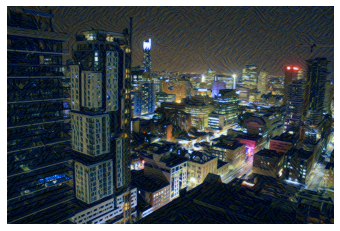

Total Loss:  1026082.9375
Iteration:  600


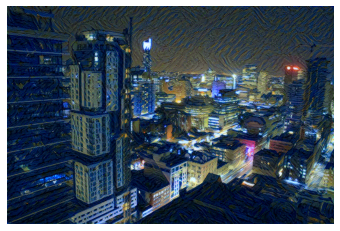

Total Loss:  699839.6875
Iteration:  900


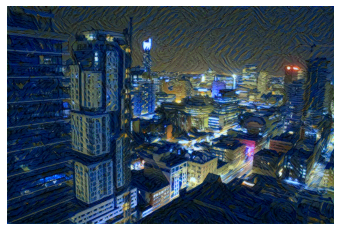

Total Loss:  542240.1875
Iteration:  1200


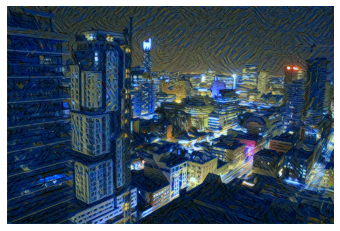

Total Loss:  426330.84375
Iteration:  1500


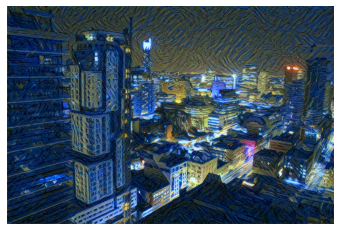

Total Loss:  335926.65625
Iteration:  1800


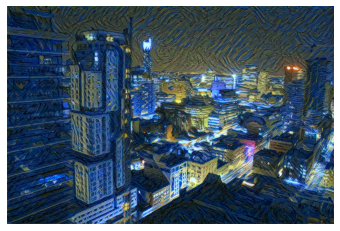

Total Loss:  264140.3125
Iteration:  2100


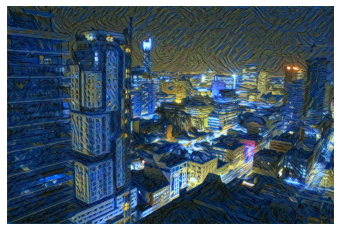

Total Loss:  206865.90625
Iteration:  2400


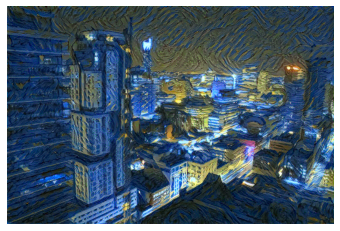

Total Loss:  161263.953125
Iteration:  2700


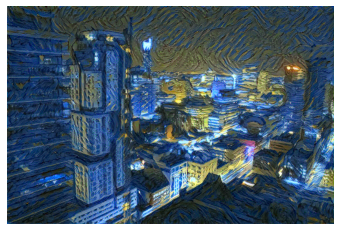

Total Loss:  125189.5078125
Iteration:  3000


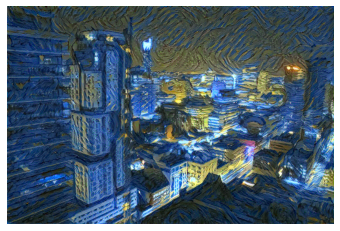

Total Loss:  96948.921875
Iteration:  3300


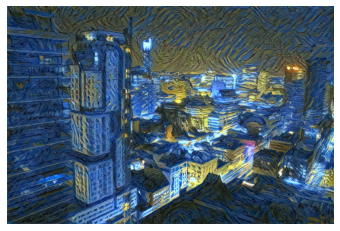

Total Loss:  75250.0546875
Iteration:  3600


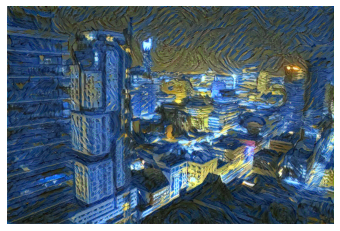

Total Loss:  58884.19140625
Iteration:  3900


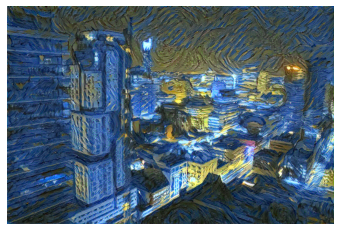

Total Loss:  46743.546875
Iteration:  4200


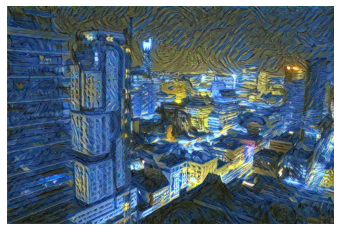

Total Loss:  37877.23828125
Iteration:  4500


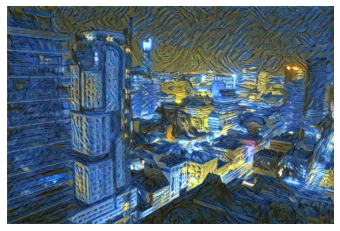

Total Loss:  31462.0
Iteration:  4800


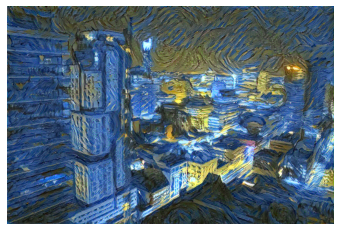

Total Loss:  26811.109375
Iteration:  5100


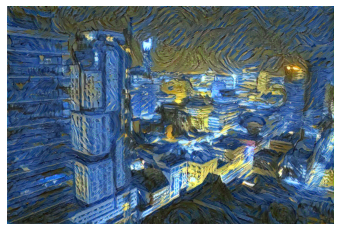

Total Loss:  23404.966796875
Iteration:  5400


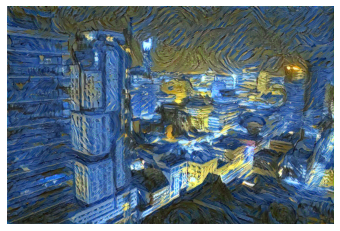

Total Loss:  20887.701171875
Iteration:  5700


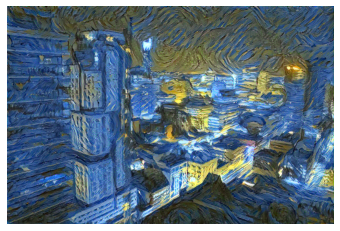

Total Loss:  19007.53515625
Iteration:  6000


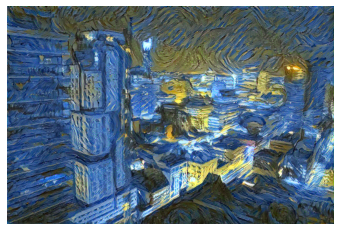

Total Loss:  17636.20703125
Iteration:  6300


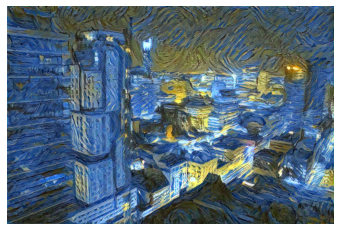

Total Loss:  16366.365234375
Iteration:  6600


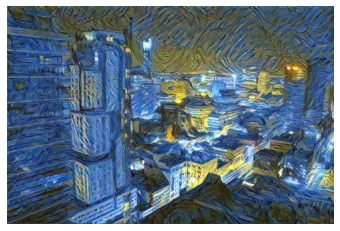

Total Loss:  15569.451171875
Iteration:  6900


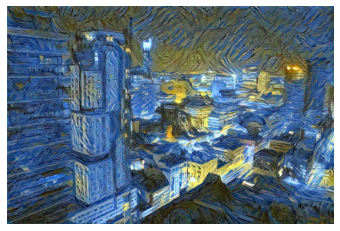

Total Loss:  14654.30078125
Iteration:  7200


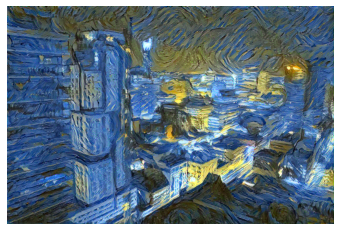

Total Loss:  14035.544921875
Iteration:  7500


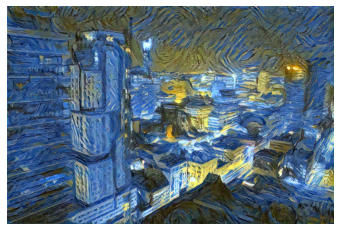

Total Loss:  13705.14453125
Iteration:  7800


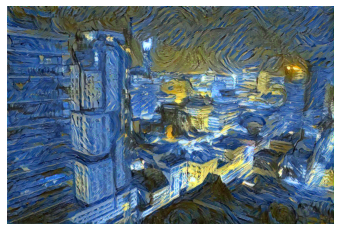

In [19]:
for i in range(1, steps + 1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
  style_loss = 0 #calculated from each layer

  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d * h * w)

  total_loss = content_weight * content_loss + style_weight * style_loss  

  optimizer.zero_grad() #remove grads from previous step
  total_loss.backward()
  optimizer.step()

  if i % show_every == 0:
    print('Total Loss: ', total_loss.item())
    print('Iteration: ', i)
    plt.imshow(im_convert(target))
    plt.axis('off')
    plt.show()

  if i % capture_frame == 0:
    image_array[counter] = im_convert(target)
    counter = counter + 1  


(-0.5, 599.5, 399.5, -0.5)

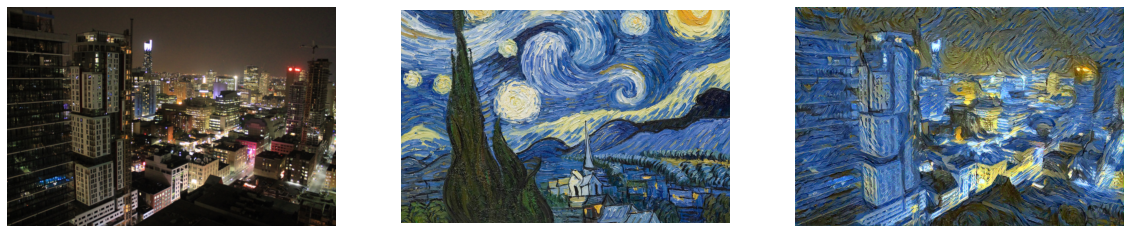

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

In [21]:
import cv2

frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output_new.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for i in range(0, 300):
  img = image_array[i]
  img = img * 255  #need to de-normalize as actual image has 0-255
  img = np.array(img, np.uint8)  #cv2 vid accepts only 8 bit integer
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)

vid.release()  

In [22]:
!ls

City.jpg  MonaLisa.jpg	output.mp4  output_new.mp4  StarryNight.jpg


In [24]:
from google.colab import files

files.download('output_new.mp4')